<a href="https://colab.research.google.com/github/BraveNewCapital/zk-py-stark/blob/master/zk_stark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install algebra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.2/720.2 kB 30.9 MB/s eta 0:00:00
  Created wheel for algebra: filename=algebra-1.2.1-py3-none-any.whl size=20841 sha256=90f59b39cc47d608fe21e37345f8ce1af9dffe7883953951a3c5339d2787dbab
  Stored in directory: /root/.cache/pip/wheels/76/a0/ac/f6497a8efda0b8f3be2ecace9aba7dca1a1aa552590aedd79e
  Created wheel for backends: filename=backends-1.5.4-cp310-cp310-linux_x86_

# Section: 1
# Finite fields

The easiest way to build a finite field is to select a prime number p
, use the elements Fp△={0,1,…,p−1}, and define the usual addition and multiplication operations in terms of their counterparts for the integers, followed by reduction modulo p. Subtraction is equivalent to addition of the left hand side to the negation of the right hand side, and negation represents multiplication by −1≡p−1modp. Similarly, division is equivalent to multiplication of the left hand side by the multiplicative inverse of the right hand side. This inverse can be found using the extended Euclidean algorithm, which on input two integers x and y, returns their greatest common divisor g along with matching Bezout coefficients a,b such that ax+by=g. Indeed, whenever gcd(x,p)=1 the inverse of x∈Fp is a because ax+bp≡1modp

. Powers of field elements can be computed with the square-and-multiply algorithm, which iterates over the bits in the expansion of the exponent, squares an accumulator variable in each iteration, and additionally multiplies it by the base element if the bit is set.

For the purpose of building STARKs we need finite fields with a particular structure1: it needs to contain a substructure of order 2k
for some sufficiently large k. We consider prime fields whose defining modulus has the form p=f⋅2k+1, where f is some cofactor that makes the number prime. In this case, the group Fp∖{0},× has a subgroup of order 2k. For all intents and purposes, one can identify this subgroup with 2k evenly spaced points on the complex unit circle.


In [3]:
# An implementation starts with the extended Euclidean algorithm, for computing multiplicative inverses.

def xgcd( x, y ):
    old_r, r = (x, y)
    old_s, s = (1, 0)
    old_t, t = (0, 1)

    while r != 0:
        quotient = old_r // r
        old_r, r = (r, old_r - quotient * r)
        old_s, s = (s, old_s - quotient * s)
        old_t, t = (t, old_t - quotient * t)

    return old_s, old_t, old_r # a, b, g

It makes sense to separate the logic concerning the field from the logic concerning the field elements. To this end, the field element contains a field object as a proper field; this field object implements the arithmetic. Furthermore, python supports operator overloading, so we can repurpose natural arithmetic operators to do field arithmetic instead.

In [4]:
class FieldElement:
    def __init__( self, value, field ):
        self.value = value
        self.field = field

    def __add__( self, right ):
        return self.field.add(self, right)

    def __mul__( self, right ):
        return self.field.multiply(self, right)

    def __sub__( self, right ):
        return self.field.subtract(self, right)

    def __truediv__( self, right ):
        return self.field.divide(self, right)

    def __neg__( self ):
        return self.field.negate(self)

    def inverse( self ):
        return self.field.inverse(self)

    # modular exponentiation -- be sure to encapsulate in parentheses!
    def __xor__( self, exponent ):
        acc = FieldElement(1, self.field)
        val = FieldElement(self.value, self.field)
        for i in reversed(range(len(bin(exponent)[2:]))):
            acc = acc * acc
            if (1 << i) & exponent != 0:
                acc = acc * val
        return acc

    def __eq__( self, other ):
        return self.value == other.value

    def __neq__( self, other ):
        return self.value != other.value

    def __str__( self ):
        return str(self.value)

    def __bytes__( self ):
        return bytes(str(self).encode())

    def is_zero( self ):
        if self.value == 0:
            return True
        else:
            return False

class Field:
    def __init__( self, p ):
        self.p = p

    def zero( self ):
        return FieldElement(0, self)

    def one( self ):
        return FieldElement(1, self)

    def multiply( self, left, right ):
        return FieldElement((left.value * right.value) % self.p, self)

    def add( self, left, right ):
        return FieldElement((left.value + right.value) % self.p, self)

    def subtract( self, left, right ):
        return FieldElement((self.p + left.value - right.value) % self.p, self)

    def negate( self, operand ):
        return FieldElement((self.p - operand.value) % self.p, self)

    def inverse( self, operand ):
        a, b, g = xgcd(operand.value, self.p)
        return FieldElement(a, self)

    def divide( self, left, right ):
        assert(not right.is_zero()), "divide by zero"
        a, b, g = xgcd(right.value, self.p)
        return FieldElement(left.value * a % self.p, self)
  


Implementing fields generically is nice. However, in this tutorial we will not use any other field than the one with `1+407⋅2119` elements. This field has a sufficiently large subgroup of power-of-two order.

In [5]:
    def main():
        p = 1 + 407 * ( 1 << 119 ) # 1 + 11 * 37 * 2^119
        return Field(p)

Besides ensuring that the subgroup of power-of-two order exists, the code also needs to supply the user with a generator for the entire multiplicative group, as well as the power-of-two subgroups. A generator for such a subgroup of order n will be called a primitive nth root.

In [6]:
    def generator( self ):
        assert(self.p == 1 + 407 * ( 1 << 119 )), "Do not know generator for other fields beyond 1+407*2^119"
        return FieldElement(85408008396924667383611388730472331217, self)
        
    def primitive_nth_root( self, n ):
        if self.p == 1 + 407 * ( 1 << 119 ):
            assert(n <= 1 << 119 and (n & (n-1)) == 0), "Field does not have nth root of unity where n > 2^119 or not power of two."
            root = FieldElement(85408008396924667383611388730472331217, self)
            order = 1 << 119
            while order != n:
                root = root^2
                order = order/2
            return root
        else:
            assert(False), "Unknown field, can't return root of unity."

Lastly, the protocol requires the ability to sample field elements randomly and pseudorandomly. To do this, the user supplies random bytes and the field logic turns them into a field element. The user should take care to provide enough random bytes.

In [7]:
    def sample( self, byte_array ):
        acc = 0
        for b in byte_array:
            acc = (acc << 8) ^ int(b)
        return FieldElement(acc % self.p, self)

Univariate Polynomials

A univariate polynomial is a weighted sum of non-negative powers of a single formal indeterminate. We write polynomials as a formal sum of terms, i.e: 


# f(X) = c₀ + c₁ ⋅ X + ⋯ + c_d Xᵈ
## ∴
# f(x) = ∑ᵢ₌₀ᵈ cᵢ Xⁱ


Because: 
  1. The value of the indeterminate X is generally unknown  
  2. This form emphasises the polynomial’s semantic origin and is thus more conducive to building intuition.
In these expressions, the `cᵢ` are called coefficients and *d* represents the polynomial’s degree.

**Univariate polynomials** are immensely useful in proof systems because relations that apply to their coefficient vectors extend to their values on a potentially much larger domain. If polynomials are equal, they are equal everywhere; whereas if they are unequal, they are unequal almost everywhere. By this feature, univariate polynomials reduce claims about large vectors to claims about the values of their corresponding polynomials in a small selection of sufficiently random points.

An implementation of univariate polynomial algebra starts with overloading the standard arithmetic operators to compute the right function of the polynomials’ coefficient vectors. One important point requires special attention. It is impossible for the leading coefficient of a polynomial to be zero, since the leading coefficient means the coefficient of the highest-degree non-zero term.

However, the implemented vector of coefficients might have trailing zeros, which should be ignored for all intents and purposes. The degree function comes in handy; it is defined here as one less than the length of the vector of coefficients after ignoring trailing zeros. This also means that the zero polynomial has degree −1
even though −∞ makes more sense.

In [8]:
from algebra import *

class Polynomial:
    def __init__( self, coefficients ):
        self.coefficients = [c for c in coefficients]

    def degree( self ):
        if self.coefficients == []:
            return -1
        zero = self.coefficients[0].field.zero()
        if self.coefficients == [zero] * len(self.coefficients):
            return -1
        maxindex = 0
        for i in range(len(self.coefficients)):
            if self.coefficients[i] != zero:
                maxindex = i
        return maxindex

    def __neg__( self ):
        return Polynomial([-c for c in self.coefficients])

    def __add__( self, other ):
        if self.degree() == -1:
            return other
        elif other.degree() == -1:
            return self
        field = self.coefficients[0].field
        coeffs = [field.zero()] * max(len(self.coefficients), len(other.coefficients))
        for i in range(len(self.coefficients)):
            coeffs[i] = coeffs[i] + self.coefficients[i]
        for i in range(len(other.coefficients)):
            coeffs[i] = coeffs[i] + other.coefficients[i]
        return Polynomial(coeffs)

    def __sub__( self, other ):
        return self.__add__(-other)

    def __mul__(self, other ):
        if self.coefficients == [] or other.coefficients == []:
            return Polynomial([])
        zero = self.coefficients[0].field.zero()
        buf = [zero] * (len(self.coefficients) + len(other.coefficients) - 1)
        for i in range(len(self.coefficients)):
            if self.coefficients[i].is_zero():
                continue # optimization for sparse polynomials
            for j in range(len(other.coefficients)):
                buf[i+j] = buf[i+j] + self.coefficients[i] * other.coefficients[j]
        return Polynomial(buf)

    def __eq__( self, other ):
        if self.degree() != other.degree():
            return False
        if self.degree() == -1:
            return True
        return all(self.coefficients[i] == other.coefficients[i] for i in range(len(self.coefficients)))

    def __neq__( self, other ):
        return not self.__eq__(other)

    def is_zero( self ):
        if self.degree() == -1:
            return True
        return False

    def leading_coefficient( self ):
        return self.coefficients[self.degree()]



### *This always gets somewhat tricky when implementing division of polynomials.* 
#### The intuition behind the schoolbook algorithm is that in every iteration you multiply the dividend by the correct term so as to generate a cancellation of leading terms. Once no such term exists, you have your remainder.


In [9]:
    def divide( numerator, denominator ):
        if denominator.degree() == -1:
            return None
        if numerator.degree() < denominator.degree():
            return (Polynomial([]), numerator)
        field = denominator.coefficients[0].field
        remainder = Polynomial([n for n in numerator.coefficients])
        quotient_coefficients = [field.zero() for i in range(numerator.degree()-denominator.degree()+1)]
        for i in range(numerator.degree()-denominator.degree()+1):
            if remainder.degree() < denominator.degree():
                break
            coefficient = remainder.leading_coefficient() / denominator.leading_coefficient()
            shift = remainder.degree() - denominator.degree()
            subtractee = Polynomial([field.zero()] * shift + [coefficient]) * denominator
            quotient_coefficients[shift] = coefficient
            remainder = remainder - subtractee
        quotient = Polynomial(quotient_coefficients)
        return quotient, remainder

    def __truediv__( self, other ):
        quo, rem = Polynomial.divide(self, other)
        assert(rem.is_zero()), "cannot perform polynomial division because remainder is not zero"
        return quo

    def __mod__( self, other ):
        quo, rem = Polynomial.divide(self, other)
        return rem

### *In terms of basic arithmetic operations, it is worth including a powering map, although for syntactic sugar, rather than performance.*

In [10]:
    def __xor__( self, exponent ):
        if self.is_zero():
            return Polynomial([])
        if exponent == 0:
            return Polynomial([self.coefficients[0].field.one()])
        acc = Polynomial([self.coefficients[0].field.one()])
        for i in reversed(range(len(bin(exponent)[2:]))):
            acc = acc * acc
            if (1 << i) & exponent != 0:
                acc = acc * self
        return acc


## A polynomial is quite pointless if it does not admit the computation of its value in a given arbitrary point. For STARKs we need someting more general – polynomial evaluation on a domain of values, rather in a single point.
#### Performance is not a concern at this point so the following implementation follows a straightforward iterative method. 
#### Conversely, STARKs also require polynomial interpolation where the x-coordinates are themselves another known range of values. 
#### Once again, performance is not an immediate issue so for the time being standard Lagrange interpolation suffices.

In [11]:
    def evaluate( self, point ):
        xi = point.field.one()
        value = point.field.zero()
        for c in self.coefficients:
            value = value + c * xi
            xi = xi * point
        return value

    def evaluate_domain( self, domain ):
        return [self.evaluate(d) for d in domain]

    def interpolate_domain( domain, values ):
        assert(len(domain) == len(values)), "number of elements in domain does not match number of values -- cannot interpolate"
        assert(len(domain) > 0), "cannot interpolate between zero points"
        field = domain[0].field
        x = Polynomial([field.zero(), field.one()])
        acc = Polynomial([])
        for i in range(len(domain)):
            prod = Polynomial([values[i]])
            for j in range(len(domain)):
                if j == i:
                    continue
                prod = prod * (x - Polynomial([domain[j]])) * Polynomial([(domain[i] - domain[j]).inverse()])
            acc = acc + prod
        return acc

Speaking of domains: one thing that recurs time and again is the computation of polynomials that vanish on them. Any such polynomial is the multiple of:

 # ZD(X) = ∏_d_ _∈_ _D (X−d)
 
the unique *monic2* lowest-degree polynomial that takes the value 0 in all the points of DD. This polynomial is usually called the vanishing polynomial and sometimes the zerofier. This tutorial prefers the second term.

In [12]:
    def zerofier_domain( domain ):
        field = domain[0].field
        x = Polynomial([field.zero(), field.one()])
        acc = Polynomial([field.one()])
        for d in domain:
            acc = acc * (x - Polynomial([d]))
        return acc

## Another useful tool is the ability to scale polynomials.
### Specifically, this means obtaining the vector of coefficients of:
 ## f(c ⋅ X) from that of f(X)
#### This function is particularly useful when `𝕗(X) →` is defined to take a sequence of values on the powers of c, such that `vᵢ = f(cⁱ)` Then `𝕗(c ⋅ X)` represents the same sequence of values, but shifted by one position.

In [13]:
    def scale( self, factor ):
        return Polynomial([(factor^i) * self.coefficients[i] for i in range(len(self.coefficients))])

###The last function [`scale(self, factor)`], belongs to the univariate polynomial module and anticipates some key operations in the FRI protocol; namely testing if a three-tuple of points fall on the same line, the term for which is ***colinearity***.

In [14]:
def test_colinearity( points ):
    domain = [p[0] for p in points]
    values = [p[1] for p in points]
    polynomial = Polynomial.interpolate_domain(domain, values)
    return polynomial.degree() <= 1


### Before moving on to the next section, it is worth pausing to note that all ingredients are in place for finite extension fields, or simply extension fields.
### A finite field is simply a set equipped with addition and multiplication operators that behave according to high school algebra rules, e.g. every nonzero element has an inverse, or no two nonzero elements multiplied give zero.

#### There are two ways to obtain them:

  1. Start with the set of integers, and reduce the result of any addition or multiplication modulo a given prime number pp.
  2. Start with the set of polynomials over a finite field, and reduce the result of any addition or multiplication modulo a given irreducible polynomial `𝕡(X)`. A polynomial is irreducible when it cannot be decomposed as the product of two smaller polynomials, analogously to prime numbers.

### The point is that it is possible to do the arithmetization in a smaller field than cryptographic compilation step, as long as the latter step uses an extension field of that of the former. Specifically and for example, EthSTARK operates over the finite field defined by a 62-bit prime, but the FRI step operates over a quadratic extension field thereof in order to target a higher security level.

*This tutorial will not use extension fields, and so an elaborate discussion of the topic is out of scope.*

---

# Section: 2
# Multivariate Polynomials

#### Multivariate polynomials extend the concept of univariate polynomials by applying it to multiple variables, not just a single indeterminate like 'X', but also incorporating 𝕏, 𝕐, ℤ, …. Univariate polynomials simplify complex arguments related to large vectors into concise propositions about scalar values at random points. Similarly, multivariate polynomials play a significant role by defining the arithmetic conditions that a comprehensive computation needs to fulfill.



#### For example, consider the arithmetic-geometric mean, which is defined as the limit of either the first or second coordinate (which are equal in the limit) of the sequence 
$(a, b) \mapsto \left( \frac{a+b}{2}, \sqrt{a \cdot b} \right)$,
 to a give a starting point $(a_0, b_0)$.
 
 In order to prove the integrity of several iterations of this process, we need a set of multivariate polynomials that capture the constraints of the correct application of a single iterations relationship with the current state; $X_0, X_1$ to the next state, $Y_0, Y_1.$
 
 By capture, we mean that the polynomial evaluates to zero if the computation is integral.
 
 These polynomials might be 
 ### $m_0(X_0, X_1, Y_0, Y_1) = Y_0 - \frac{X_0 + X_1}{2}$ 
 and
 ###  $m_1(X_0, X_1, Y_0, Y_1) = Y_1^2 - X_0 \cdot X_1.$ 

###### *Note that the natural choice: $m_1(X_0, X_1, Y_0, Y_1) = Y_1 - \sqrt{X_0 \cdot X_1}$ is not in fact a polynomial, but has the same zeros.*

The preferred structural form for implementing univariate polynomials is a list of coefficients. In contrast, the ideal structure for multivariate polynomials is a dictionary. This dictionary maps exponent vectors to their corresponding coefficients. However, it's important to disregard any coefficients that hold a value of zero within this dictionary, as they don't contribute to the polynomial.

To implement these structures effectively, the initial action is to customize the basic arithmetic operators. This is done through a process known as overloading, which allows the operators to function with the newly defined structures. In addition, you also need to customize the basic constructors, which help to initialize the new objects. Lastly, standard functionalities should be redefined to work with these new polynomial structures. By doing these, you maintain the familiar methods of interaction while adjusting to the new polynomial contexts.

In [15]:
class MPolynomial:
    def __init__( self, dictionary ):
        self.dictionary = dictionary

    def zero():
        return MPolynomial(dict())

    def __add__( self, other ):
        dictionary = dict()
        num_variables = max([len(k) for k in self.dictionary.keys()] + [len(k) for k in other.dictionary.keys()])
        for k, v in self.dictionary.items():
            pad = list(k) + [0] * (num_variables - len(k))
            pad = tuple(pad)
            dictionary[pad] = v
        for k, v in other.dictionary.items():
            pad = list(k) + [0] * (num_variables - len(k))
            pad = tuple(pad)
            if pad in dictionary.keys():
                dictionary[pad] = dictionary[pad] + v
            else:
                dictionary[pad] = v
        return MPolynomial(dictionary)

    def __mul__( self, other ):
        dictionary = dict()
        num_variables = max([len(k) for k in self.dictionary.keys()] + [len(k) for k in other.dictionary.keys()])
        for k0, v0 in self.dictionary.items():
            for k1, v1 in other.dictionary.items():
                exponent = [0] * num_variables
                for k in range(len(k0)):
                    exponent[k] += k0[k]
                for k in range(len(k1)):
                    exponent[k] += k1[k]
                exponent = tuple(exponent)
                if exponent in dictionary.keys():
                    dictionary[exponent] = dictionary[exponent] + v0 * v1
                else:
                    dictionary[exponent] = v0 * v1
        return MPolynomial(dictionary)

    def __sub__( self, other ):
        return self + (-other)

    def __neg__( self ):
        dictionary = dict()
        for k, v in self.dictionary.items():
            dictionary[k] = -v
        return MPolynomial(dictionary)

    def __xor__( self, exponent ):
        if self.is_zero():
            return MPolynomial(dict())
        field = list(self.dictionary.values())[0].field
        num_variables = len(list(self.dictionary.keys())[0])
        exp = [0] * num_variables
        acc = MPolynomial({tuple(exp): field.one()})
        for b in bin(exponent)[2:]:
            acc = acc * acc
            if b == '1':
                acc = acc * self
        return acc

    def constant( element ):
        return MPolynomial({tuple([0]): element})

    def is_zero( self ):
        if not self.dictionary:
            return True
        else:
            for v in self.dictionary.values():
                if v.is_zero() == False:
                    return False
            return True

    def variables( num_variables, field ):
        variables = []
        for i in range(num_variables):
            exponent = [0] * i + [1] + [0] * (num_variables - i - 1)
            variables = variables + [MPolynomial({tuple(exponent): field.one()})]
        return variables


### As multivariate polynomials represent an expansion of univariate polynomials, it's essential to have a method to transfer the logic previously established for the univariate class.

### The following function `lift(polynomial, variable_index)` accomplishes this by elevating a univariate polynomial (the first argument) into the realm of multivariate polynomials.

###The function's second argument is the index of the variable that matches the univariate variable, effectively ensuring continuity between the two classes.

In [16]:
    def lift( polynomial, variable_index ):
        if polynomial.is_zero():
            return MPolynomial({})
        field = polynomial.coefficients[0].field
        variables = MPolynomial.variables(variable_index+1, field)
        x = variables[-1]
        acc = MPolynomial({})
        for i in range(len(polynomial.coefficients)):
            acc = acc + MPolynomial.constant(polynomial.coefficients[i]) * (x^i)
        return acc

### The next step involves evaluation.

#### In this process, a tuple of scalars - or single-valued entities - must be supplied as the argument. This tuple is necessary as each indeterminate in the multivariate polynomial requires a corresponding value assignment.

#### However, it's worthwhile to note a special feature utilized in the ZK-STARK, where the evaluation is symbolic rather than literal.

#### This means that rather than evaluating the multivariate polynomial using a tuple of scalars, a tuple of univariate polynomials is used instead.

#### Consequently, the output of this evaluation isn't a single scalar value but rather a newly generated univariate polynomial. This distinct method allows the evaluation to maintain a level of abstraction, aiding in complex computations.

In [17]:
    def evaluate( self, point ):
        acc = point[0].field.zero()
        for k, v in self.dictionary.items():
            prod = v
            for i in range(len(k)):
                prod = prod * (point[i]^k[i])
            acc = acc + prod
        return acc

    def evaluate_symbolic( self, point ):
        acc = Polynomial([])
        for k, v in self.dictionary.items():
            prod = Polynomial([v])
            for i in range(len(k)):
                prod = prod * (point[i]^k[i])
            acc = acc + prod
        return acc

# The **Fiat-Shamir** Transform

In an interactive public coin protocol, the verifier communicates solely using random messages.
These messages are generated from a universally accessible distribution, ensuring any party could theoretically produce the same results.

The goal is a protocol that remains non-interactive while preserving the same proof capability, without compromising the security of the system.

This is precisely what the **Fiat-Shamir Transform** accomplishes, effectively streamlining the process while maintaining a high level of integrity and security.

---




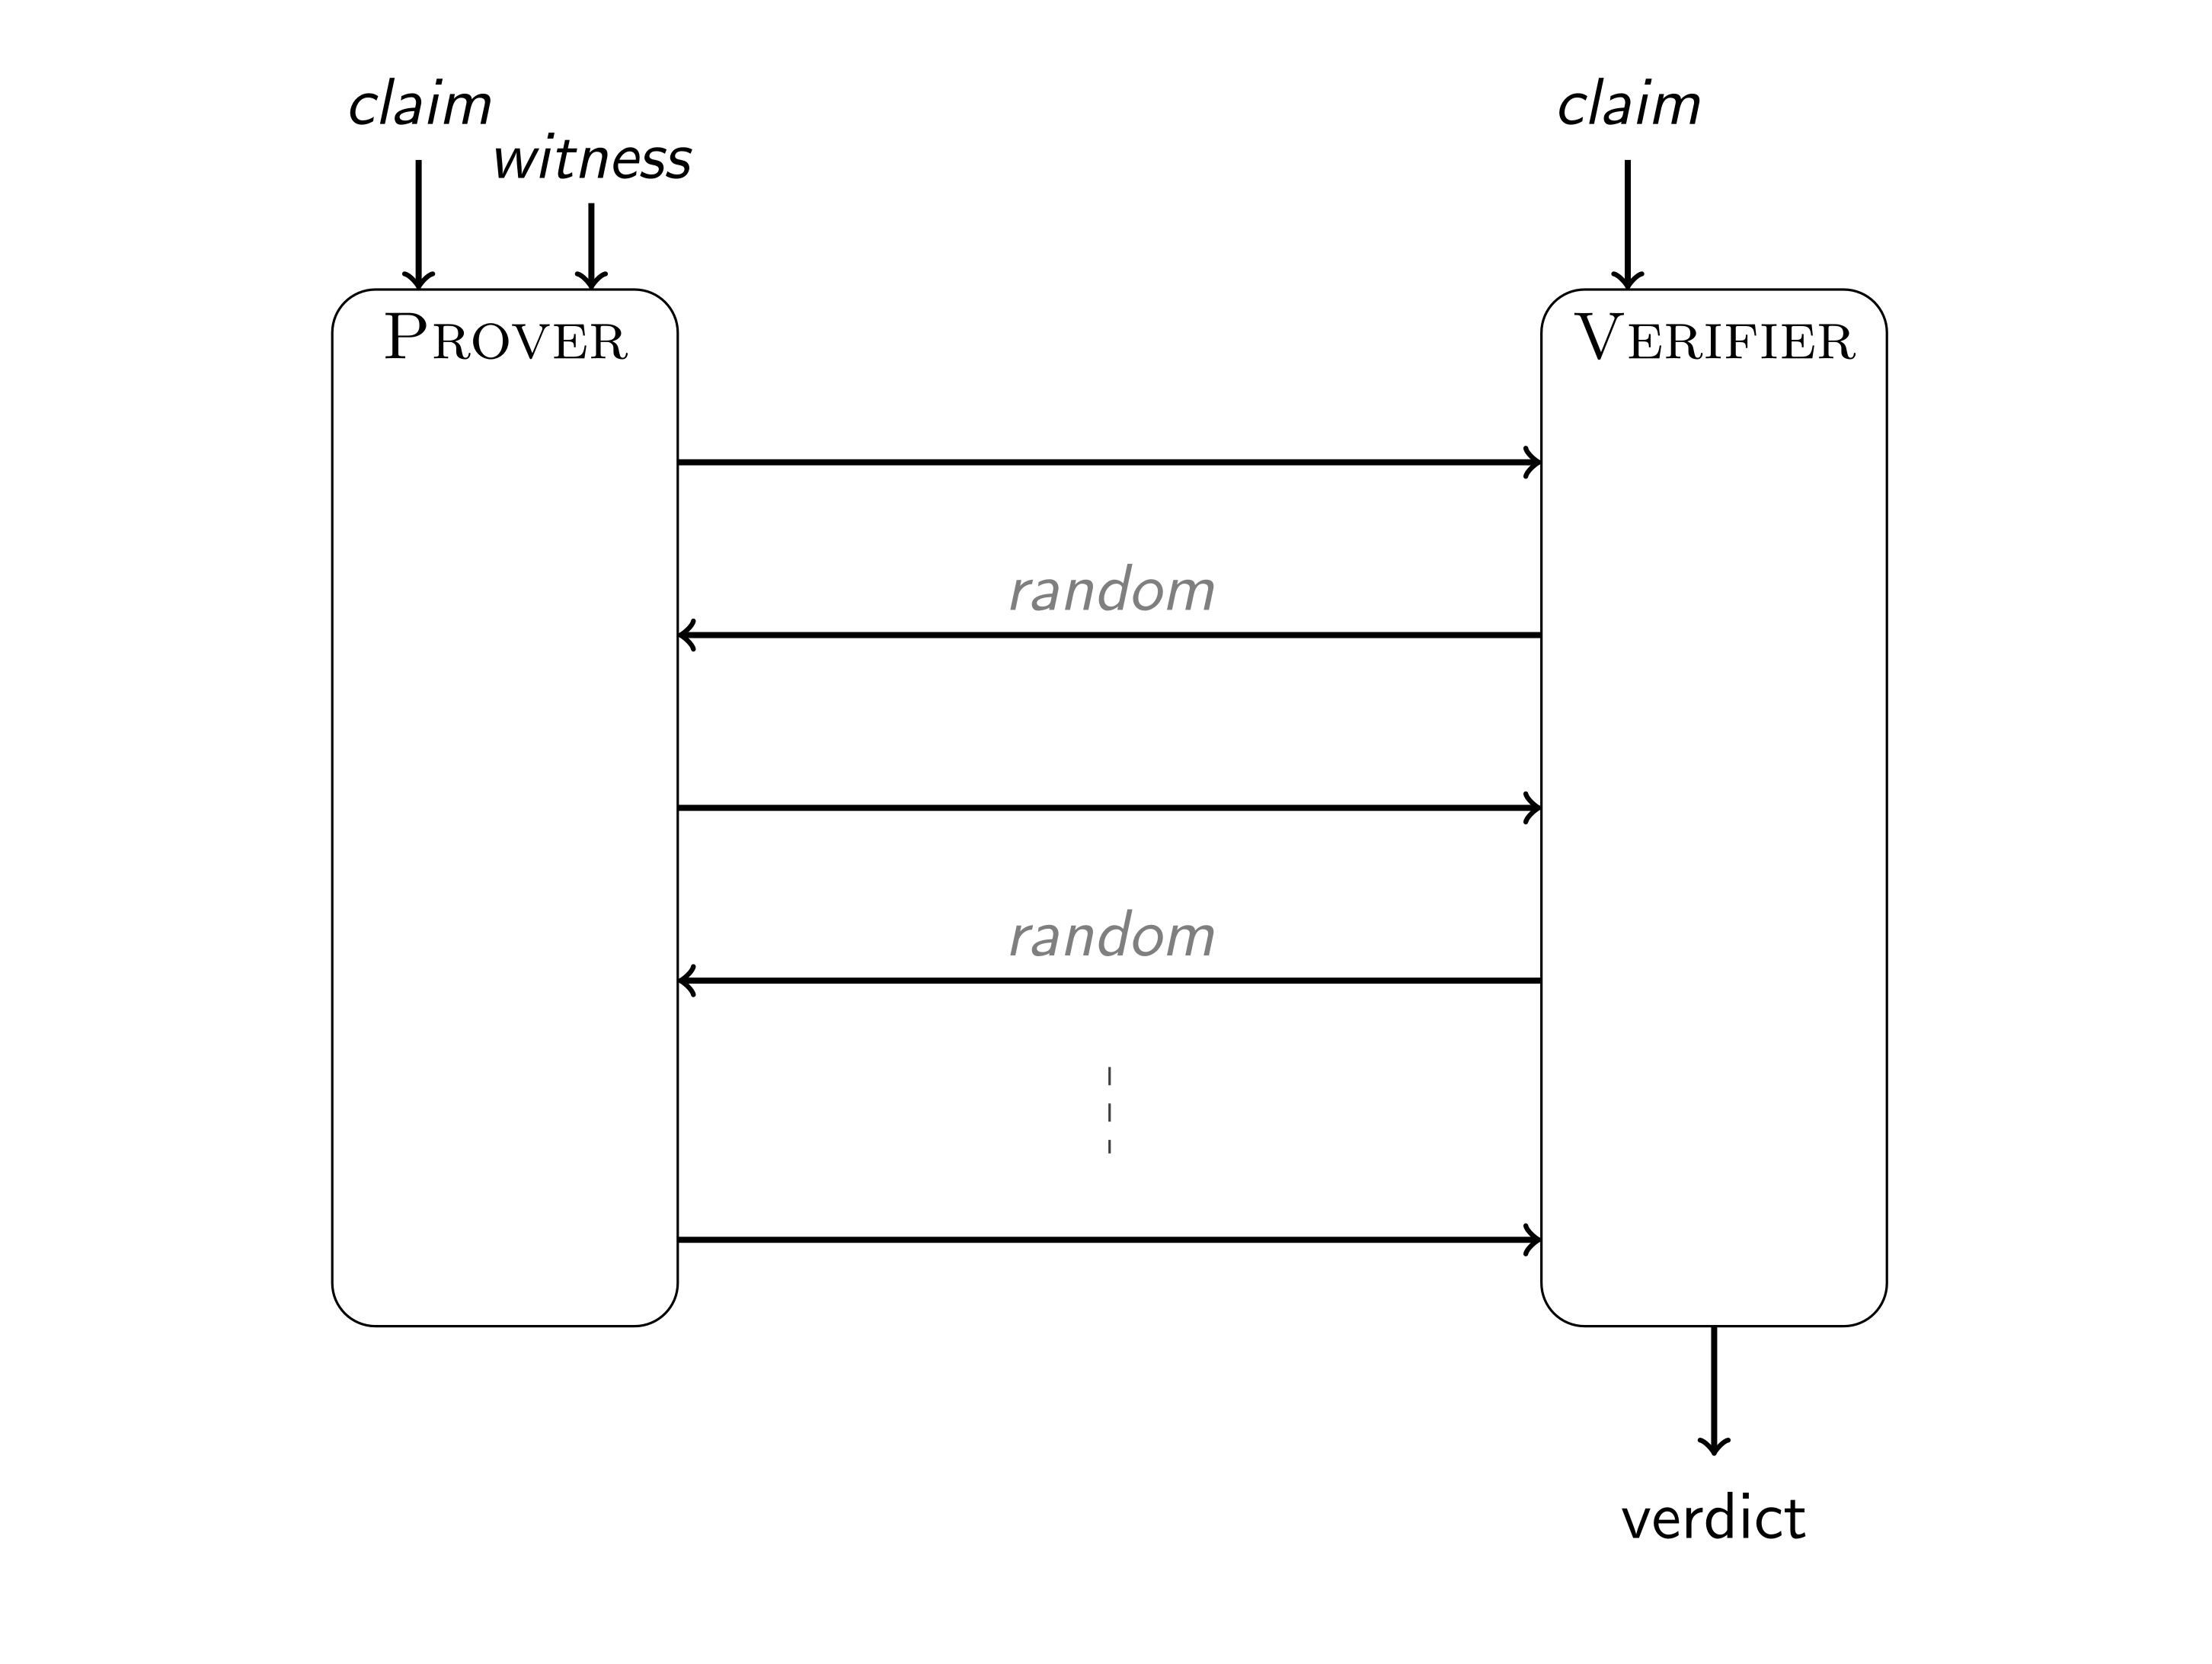

---

#### It turns out that for generating security against malicious provers, generating the verifier’s messages randomly as the interactive protocol stipulates, is **overkill**.

#### It is sufficient that the verifier’s messages be difficult to predict by the prover. Hash functions are deterministic but still satisfy this property of outputs being difficult to predict. So intuitively, the protocol remains secure if the verifier’s authentic randomness is replaced a hash function’s pseudorandom output. It is necessary to restrict the prover’s control over what input goes into the hash function, because otherwise he can grind until he finds a suitable output. It suffices to set the input to the transcript of the protocol up until the point where the verifier’s message is needed.

#### This is exactly the intuition behind the Fiat-Shamir transform: replace the verifier’s random messages by the hash of the transcript of the protocol up until those points. The Fiat-Shamir heuristic states that this transform retains security. In an idealized model of the hash function called the random oracle model, this security is provable.

#### The Fiat-Shamir transform presents the first engineering challenge. The interactive protocol is described in terms of a channel which passes messages from prover to receiver or the other way around. The transform serializes this communication while enabling a description of the prover that makes abstraction of it. The transform does modify the description of the verifier, which becomes deterministic.

### *A proof stream is a useful concept to simulate this channel...*

#### The difference with respect to regular streams in programming is that there is no actual transmission to another process or computer taking place, and nor do sender and receiver need to operate simultaneously. It is not a simple queue either because the prover and the verifier have access to a function that computes pseudorandomness by hashing their view of the channel.


*   For the prover, this view is the entire list of all messages sent so far.   
*   For the verifier, this view is the sublist of messages read so far. The verifier’s messages are not added to the list because 
they can be deterministically computed from them.

#### Given the list of prover’s messages, serialization is straightforward. The non-interactive proof is exactly this serialization.

---

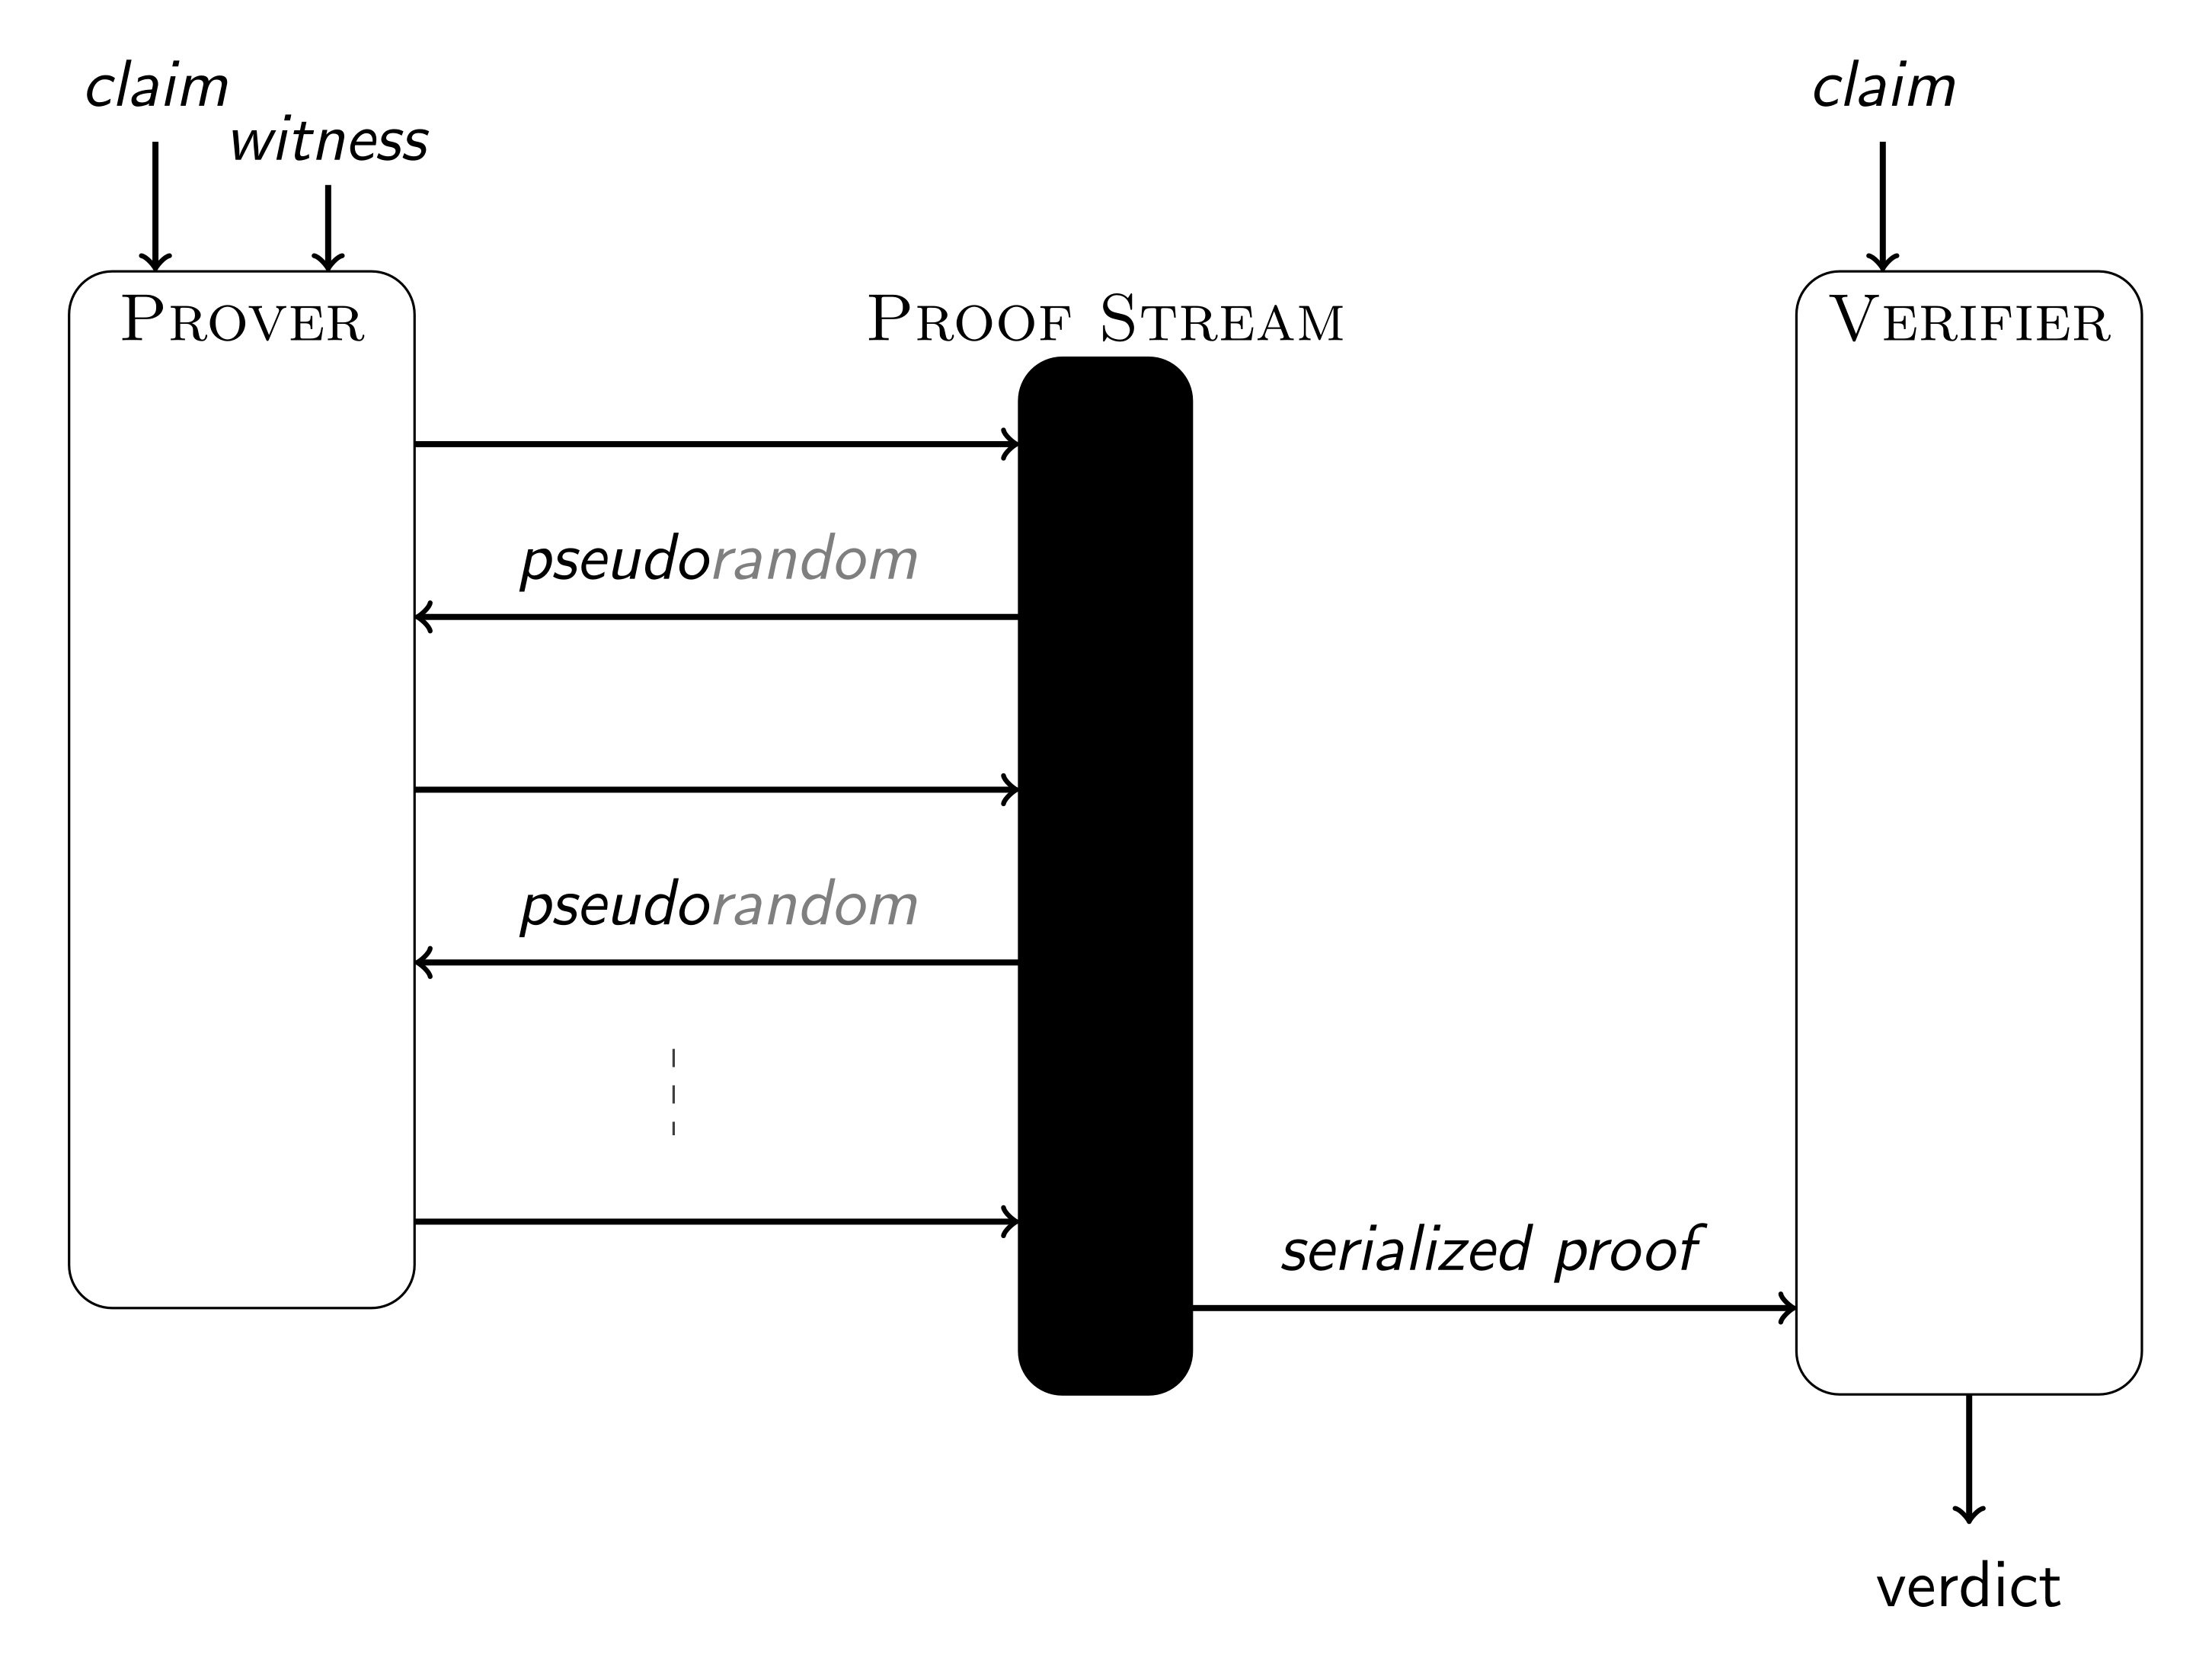

---

### In terms of implementation, what is needed is a class ProofStream that supports 3 functionalities.

1.  Pushing and pulling objects to and from a queue. The queue is simulated by a list with a read index. Whenever an item is pushed, it is appended. Whenever an item is pulled, the read index is incremented by one.
2.  Serialization and deserialization. The amazing python library pickle does this.
3.  Fiat-Shamir. Hashing is done below by first serializing the queue or the first part of it, and then applying SHAKE-256. SHAKE-256 admits a variable output length, which the particular application may want to set. By default the output length is set to 32 bytes.

---

In [18]:
from hashlib import shake_256
import pickle as pickle # serialization

class ProofStream:
    def __init__( self ):
        self.objects = []
        self.read_index = 0

    def push( self, obj ):
        self.objects += [obj]

    def pull( self ):
        assert(self.read_index < len(self.objects)), "ProofStream: cannot pull object; queue empty."
        obj = self.objects[self.read_index]
        self.read_index += 1
        return obj

    def serialize( self ):
        return pickle.dumps(self.objects)

    def deserialize( bb ):
        ps = ProofStream()
        ps.objects = pickle.loads(bb)
        return ps

    def prover_fiat_shamir( self, num_bytes=32 ):
        return shake_256(self.serialize()).digest(num_bytes)

    def verifier_fiat_shamir( self, num_bytes=32 ):
        return shake_256(pickle.dumps(self.objects[:self.read_index])).digest(num_bytes)


# Merkle Trees

A Merkle tree (in our context) is a vector commitment scheme built from a collision-resistant hash function.
Specifically, it allows the user to commit to an array of 2^N items such that:

  * The commitment is a single hash digest and this commitment is binding – it represents the array in a way that prevents the user from changing it without first breaking the hash function;
  
  * For any index i $\in \lbrace0, \ldots, 2^N-1\rbrace$, the value in location i of the array represented by the commitment can be proven with N more hash digests.

---

##### In the binary tree's structure, each leaf symbolizes the unique hash, or digital fingerprint, of a data element. Ascending the tree, every non-leaf node encapsulates the hash derived from the concatenation of its two children nodes, ensuring a secure chain of data.

##### The tree's pinnacle, or the root, signifies the commitment—a binding pledge to a specific set of data. The route from a particular leaf to the root - the "path" - plays a crucial role in membership proof. It consists of all sibling nodes lying along the path, helping verify the origin and authenticity of the data.

##### This collection of sibling nodes is referred to as an 'authentication path.' It equips the verifier with n total preimages - original or initial versions of the data - handed to the hash function at each step along the path. The journey concludes at the root node, where a final examination of the data takes place. This process reinforces the verification and validation of data integrity within the binary tree structure.

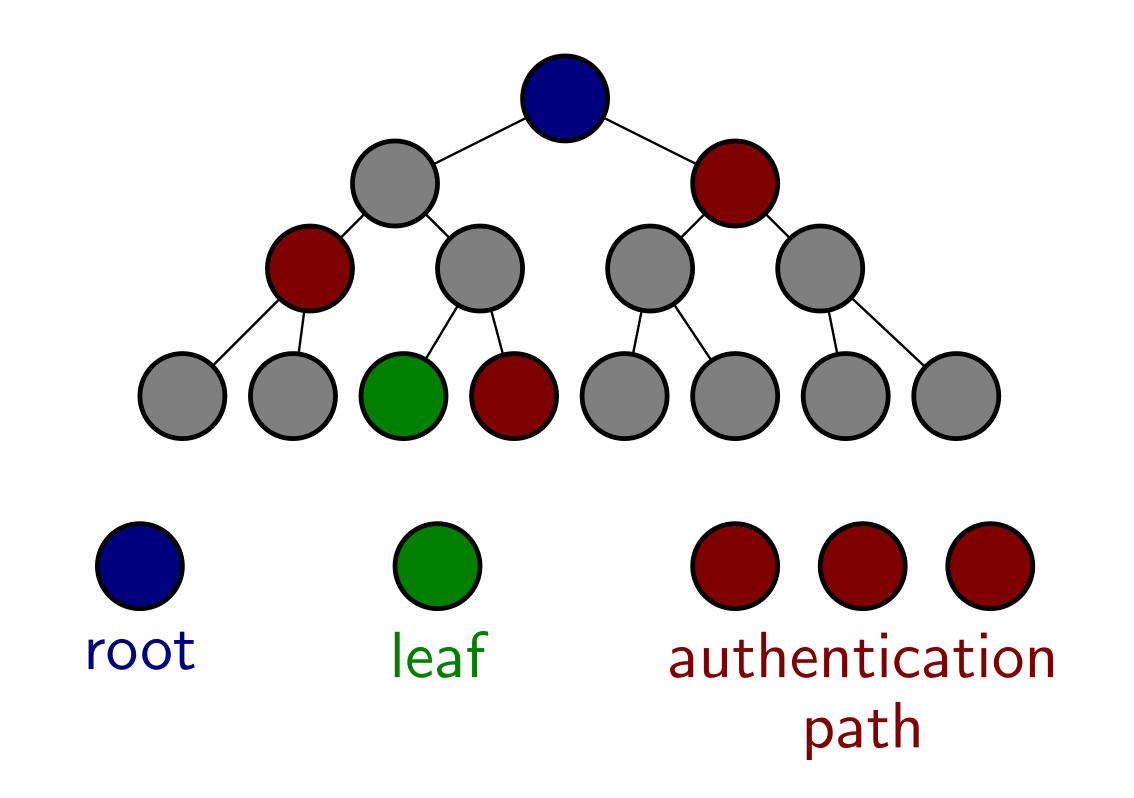

---

An implementation of this construct needs to provide three functionalities:

  * **commit** –> computes the Merkle root of a given array.
  * **open** – computes the authentication path of an indicated leaf in the Merkle tree.
  * **verify** – verifies that a given leaf is an element of the committed vector at the given index.

###### In scenarios where performance isn't a concern *(and for this notebook context, it truly isn't)*, the inherent recursiveness of these functionalities paves the way for a remarkably expressive and intuitive functional implementation:

In [1]:
from hashlib import blake2b

class Merkle:
    H = blake2b

    def commit_( leafs ):
        assert(len(leafs) & (len(leafs)-1) == 0), "length must be power of two"
        if len(leafs) == 1:
            return leafs[0]
        else:
            return Merkle.H(Merkle.commit_(leafs[:len(leafs)//2]) + Merkle.commit_(leafs[len(leafs)//2:])).digest()
    
    def open_( index, leafs ):
        assert(len(leafs) & (len(leafs)-1) == 0), "length must be power of two"
        assert(0 <= index and index < len(leafs)), "cannot open invalid index"
        if len(leafs) == 2:
            return [leafs[1 - index]]
        elif index < (len(leafs)/2):
            return Merkle.open_(index, leafs[:len(leafs)//2]) + [Merkle.commit_(leafs[len(leafs)//2:])]
        else:
            return Merkle.open_(index - len(leafs)//2, leafs[len(leafs)//2:]) + [Merkle.commit_(leafs[:len(leafs)//2])]
    
    def verify_( root, index, path, leaf ):
        assert(0 <= index and index < (1 << len(path))), "cannot verify invalid index"
        if len(path) == 1:
            if index == 0:
                return root == Merkle.H(leaf + path[0]).digest()
            else:
                return root == Merkle.H(path[0] + leaf).digest()
        else:
            if index % 2 == 0:
                return Merkle.verify_(root, index >> 1, path[1:], Merkle.H(leaf + path[0]).digest())
            else:
                return Merkle.verify_(root, index >> 1, path[1:], Merkle.H(path[0] + leaf).digest())
# Commit, Open & Verify methods.
    def commit( data_array ):
        return Merkle.commit_([Merkle.H(bytes(da)).digest() for da in data_array])

    def open( index, data_array ):
        return Merkle.open_(index, [Merkle.H(bytes(da)).digest() for da in data_array])

    def verify( root, index, path, data_element ):
        return Merkle.verify_(root, index, path, Merkle.H(bytes(data_element)).digest())


#### This functional approach, while efficient, misses *one crucial detail*: **data objects we often deal with are seldom hash digests**.

#### To make these functions compatible with real-world data, we must first convert these data elements into hash forms.

#### This hashing step, a form of preprocessing, is integral to the Merkle tree's logic. Therefore we incorporate this to the Merkle tree class to accommodate this hashing process.

#Part 3: **FRI**
####*Fast Reed-Solomon IOP*

FRI is a protocol that establishes that a committed polynomial has a bounded degree.

The acronym FRI stands for "Fast Reed-Solomon IOP", (interactive oracle proof) of Proximity.

FRI is presented in the language of codewords: the prover sends codewords to the verifier who does not read them whole but who makes oracle-queries to read them in select locations.

The codewords in this protocol are Reed-Solomon codewords, meaning that their values correspond to the evaluation of some low-degree polynomial in a list of points called the domain D.

The length of this list is larger than the number of possibly nonzero coefficients in the polynomial by a factor called the expansion factor (aka blowup factor), which is the reciprocal of the code’s rate $ \rho $.

Since the codewords represent low-degree polynomials, and since the codewords are hidden behind Merkle trees in any real-world deployment, it is arguably more natural to present FRI from the point of view of a polynomial commitment scheme, with some caveats.

There is scientific merit in separating the type of codewords from the IOP, and those two from the Merkle tree that simulates the oracles. However, from an accessibility point of view, it is beneficial to consider them as three components of one basic primitive that relates to polynomial commitment schemes. For the remainder of this tutorial, we will use the term FRI in this sense.

In a regular polynomial commitment scheme, a prover commits to a polynomial $f(X)$ that is later opens in a given point z such that it cannot equivocate between two different values of $f(z)$. The scheme consists of three algorithms:

 * **commit**, which computes a binding commitment from the polynomial.
 * **open**, which produces a proof that $f(z) = y$ for some z and for the polynomial $f(X)$ that matches with the given commitment.
 * **verify**, which verifies the proof produced by **open**.

The FRI scheme has a different interface but a later section shows how it can simulate the standard polynomial commitment scheme interface without much overhead.

FRI is a protocol between a prover and a verifier, which establishes that a given codeword belongs to a polynomial of low degree – low meaning at most \rho times the length of the codeword.

Without losing much generality, the prover knows this codeword explicitly, whereas the verifier knows only its Merkle root and leafs of his choosing, assuming the successful validation of the authentication paths that establish the leafs’ membership within the Merkle tree.

# Split-and-Fold

One of the great ideas for proof systems in recent years was split-and-fold technique. The idea is to reduce a claim to two claims of half the size. Then both claims are merged into one using random weights supplied by the verifier.

After logarithmically many steps (as a function of the size of the original claim) the claim has been reduced to one of a trivial size which is true if and only if (modulo some negligible security degradation) the original claim was true.

In the case of FRI, this computational claim asserts that the given codeword corresponds to a polynomial of low degree. Specifically, let N be the length of the codeword, and d be the maximum degree of the polynomial that it corresponds2 to. Let this polynomial be $f(X) = \sum_{i=0}^{d} c_i X^i.$

Following the divide-and-conquer strategy of the fast Fourier transform, this polynomial is divided into even and odd terms.

$f(X) = f_E(X^2) + X \cdot f_O(X^2)$ where $f_E(X^2) = \frac{f(X) + f(-X)}{2} = \sum_{i=0}^{\frac{d+1}{2}-1} c_{2i} X^{2i}$ and $f_O(X^2) = \frac{f(X) - f(-X)}{2X} = \sum_{i=0}^{\frac{d+1}{2}-1} c_{2i+1} X^{2i} \enspace $, where the expression $\frac{d+1}{2}-1$ is the number of possible even or odd terms in a degree d polynomial counting from zero.

Keep in mind that for our usecase $d=2^k-1$, for $k \in \mathbb{N_{+}}$ so the expression is always an integer. To see that this decomposition is correct, observe that for $f_E(X)$, the odd terms cancel; whereas for $f_O(X)$, it is the even terms that cancel. The key step of the protocol derives a codeword for $f^\star(X) = f_E(X) + \alpha \cdot f_O(X)$ from the codeword for $f(X)$, where \alpha is a random scalar supplied by the verifier.

Let $D$ be a subgroup of even order N of the multiplicative group of the field, and let \omega generate this subgroup: $\langle \omega \rangle = D \subset \mathbb{F}_p \backslash\lbrace 0\rbrace $

Let \lbrace f(\omega^i)\rbrace_{i=0}^{N-1} be the codeword for f(X), corresponding with evaluation on D. Let D^\star = \langle \omega^2 \rangle be another domain, of half the length, and \lbrace f_ E(\omega^{2i})\rbrace_{i=0}^{N/2-1}, \lbrace f_ O(\omega^{2i})\rbrace_{i=0}^{N/2-1}, and \lbrace f^\star(\omega^{2i})\rbrace_ {i=0}^{N/2-1} be the codewords for f_E(X), f_O(X), and f^\star(X), respectively, corresponding to evaluation on D^\star.

Expanding the definition of $f^\star(X) gives \lbrace f^\star(\omega^{2i})\rbrace_{i=0}^{N/2-1} = \lbrace f_E(\omega^{2i}) + \alpha \cdot f_O(\omega^{2i})\rbrace_{i=0}^{N/2-1} .$

Expand again, this time with the definition of $f_E(X^2)$ and $f_O(X^2)$

$\lbrace f^\star(\omega^{2i})\rbrace_{i=0}^{N/2-1} = \left\lbrace \frac{f(\omega^i) + f(-\omega^i)}{2} + \alpha \cdot \frac{f(\omega^i) - f(-\omega^i)}{2 \omega^i} \right\rbrace_{i=0}^{N/2-1} = \lbrace 2^{-1} \cdot \left( ( 1 + \alpha \cdot \omega^{-i} ) \cdot f(\omega^i) + (1 - \alpha \cdot \omega^{-i} ) \cdot f(-\omega^i) \right) \rbrace_{i=0}^{N/2-1}$

Since the order of $\omega$ is N, we have $\omega^{N/2} = -1$, and therefore $f(-\omega^i) = f(\omega^{N/2 + i})$

This substitution makes it clear that even though the index iterates over half the range (from 0 to N/2-1), all the points of $\lbrace f(\omega^i)\rbrace_{i=0}^{N-1}$

are involved in the derivation of $\lbrace f^\star(\omega^{2i})\rbrace_{i=0}^{N/2-1}$.

It does not matter that the latter codeword has half the length; its polynomial has half the degree.

At this point it is possible to describe the mechanics for one round of the FRI protocol. 
The prover commits to $f(X)$ by sending the Merkle root of its codeword to the verifier.
The verifier responds with the random challenge $\alpha$. The prover computes $f^\star(X)$ and commits to it by sending the Merkle root of $\lbrace f^\star(\omega^{2i})\rbrace_{i=0}^{N/2-1}$ to the verifier.

The verifier now has two commitments to polynomials and his task is to verify that their correct relation holds.

Specifically, the verifier should reject the proof if $f^\star(X) \neq 2^{-1} \cdot \left( (1 + \alpha X^{-1}) \cdot f(X) + (1 - \alpha X^{-1} ) \cdot f(-X) \right)$ (Ignore the case where X=0.)

To do this, the verifier randomly samples an index i $\xleftarrow{$} \lbrace 0, \ldots, N/2-1\rbrace$ which defines 3 points:

  * A: ($\omega^i, f(\omega^i)$)
  * B: ($\omega^{N/2+i}, f(\omega^{N/2+i})$)
  * C: ($\alpha, f^\star(\omega^{2i})$)

Notice that the x-coordinates of A and B are the square roots of $\omega^{2i}$
Upon receiving the index i from the verifier, the prover provides the y-coordinates along with their Merkle authentication paths. The verifier verifies these paths against their proper roots and follows up by verifying that A, B, and C fall on a straight line. This test is known as the colinearity check.

Why would A, B, and C lie on a straight line? Let’s find the line that passes through A and B and see what that means for C.

An elementary Lagrange interpolation yields $y = \sum_i y_i \prod_{j \neq i} \frac{x - x_j}{x_i - x_j} \\ = f(\omega^i) \cdot \frac{x - \omega^{N/2+i}}{\omega^{i} - \omega^{N/2+i}} + f(\omega^{N/2+i}) \cdot \frac{x - \omega^{i}}{\omega^{N/2+i} - \omega^{i}} \\ = f(\omega^i) \cdot 2^{-1} \cdot \omega^{-i} \cdot (x + \omega^i) - f(\omega^{N/2+i}) \cdot 2^{-1} \cdot \omega^{-i} (x - \omega^i) \\ = 2^{-1} \cdot \left( (1 + x \cdot \omega^{-i}) \cdot f(\omega^i) + (1 - x \cdot \omega^{-i}) \cdot f(\omega^{N/2 + i}) \right) \enspace$.

By setting x = $\alpha$ we get exactly the y-coordinate of C.

*  This description covers one round, at the end of which the prover and verifier are in the same position as they were at the start.

*  The prover wishes to establish that a given Merkle root decommits to a codeword whose defining polynomial has a bounded degree.

*  There is one important difference though: as a result of running one round of FRI, the length of the codeword as well as the number of possibly nonzero coefficients of the polynomial have halved.

*  Prover and verifier can set $f = f^\star, D = D^\star$, and repeat the process. After running $\lceil \log_2 (d+1) \rceil - 1$ rounds of FRI, where d is the degree of the original polynomial, prover and verifier end up with a constant polynomial whose codeword is also constant.

**At this point, the prover sends this constant instead of the codeword’s Merkle root, making it abundantly clear that it corresponds to a polynomial of degree 0.**

In [ ]:
}